<img src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRyXbmDYqjlTzvXPRBryziHvyhLx_7NurzioTPZBLujXUmM4nYzgSO29y4SNG5AvTB1P-Q&usqp=CAU"/>

## Sustainable and Entrepreneurial Finance - Group 15
- El Maliki Soukaynah
- Poretti Massimo
- Scalabrin Dario
- Trapanese Filippo

## Preparation

In [1]:
# Import libraries
import os
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import warnings
from statistics import mean
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import plotting, expected_returns, risk_models
from sklearn.preprocessing import normalize
import operator

# Remove warnings
warnings.filterwarnings("ignore")

# Set the directory path
DIR = os.getcwd()
DATA = os.path.join(DIR, "Data_Excel", "MSCI_ESGscores")
FF = os.path.join(DATA, "FF")
FUNDAMENTALS = os.path.join(DATA, "Fundamentals")
RETURNS = os.path.join(DATA, "Returns")
SCORES = os.path.join(DATA, "Scores")
firm_names = os.path.join(DATA, "firm_names.xlsx")

## Exercise 1

**Instruction:** Compute and report the annualized average return and annualized volatility for all individual assets. Compute the correlation between individual average returns and volatility and comment on the observed correlation. (5 points) 

In [2]:
# Load the dataframe with all company names
df_names = pd.read_excel(firm_names)
# Define the lists of emerging countries
emerging_countries = ['AE', "AR", "BR", "CL", "CN", "CO", "CZ", "EG", "GR", "HU", "ID", "IN", "KR", "KV", "MX",
                      "MY", "PE", "PH", "PK", "PL", "QA", "RU", "SA", "TH", "TR", "TW", "ZA"]
# Keep only the names of companies in emerging countries
emerging_firms = list(df_names[df_names['Country'].isin(emerging_countries)]["ISIN"])

# Load the dataframe of environmental scores
df_env_scores = pd.read_excel(os.path.join(SCORES, "Env.xlsx"))

# Drop columns where Nan values are present
df_env_scores.dropna(how = 'all', axis = 1, inplace = True)

# Retrieve the names of companies in the environmental scores dataframe
env_scores_firms = df_env_scores.columns

# Keep only companies which we have environmental scores 
filtered = [i for i in emerging_firms if i in env_scores_firms]

# Load the dataframe of return
df_returns = pd.read_excel(os.path.join(RETURNS, "monthlyreturns.xlsx"))
# Rename a column
df_returns = df_returns.rename(columns = {"Unnamed: 0" : "timestamp"})
df_timestamp_returns = df_returns["timestamp"]

# Keep only the columns of selected companies
df_returns = df_returns[filtered]

# Drop the assets with no values
df_returns.dropna(how = 'all', axis = 1, inplace = True)
# Drop two assets which are outliers
df_returns = df_returns.drop(["MXP904131325", "MXP4833F1044"], 1)
# Drop duplicates in columns
df_returns = df_returns.loc[:,~df_returns.columns.duplicated()]
df_returns.tail()

,AEA000201011,AEA001501013,AEA002001013,AED000201015,AED000601016,AED000901010,AED001301012,AED001501017,AEDFXA0M6V00,AEE000301011,...,ZAE000210688,ZAE000216537,ZAE000248498,ZAE000248506,ZAE000255360,ZAE000255915,ZAE000259479,ZAE000259701,ZAE000265971,ZAE000269890
223,0.012045,1.087475,-0.050000,-0.005255,0.008674,-0.007831,0.196843,0.000000,0.0,-0.058828,...,0.077882,-0.050505,-0.043621,-0.194835,-0.029779,-0.094230,-0.116505,0.310495,-0.023609,-0.106407
224,0.107170,-0.364762,0.205592,0.086644,0.043186,0.059195,0.009310,-0.015075,0.0,0.121028,...,0.026012,0.067376,0.091790,-0.113688,0.068572,0.107444,0.040293,0.107116,-0.056995,-0.002759
225,0.008931,-0.310345,-0.019782,0.043485,-0.049642,-0.023100,0.027671,0.030612,0.0,-0.017376,...,-0.052582,-0.079734,0.056919,-0.162197,-0.144279,0.111818,0.158451,-0.102972,0.120879,0.037288
226,0.021308,0.000000,0.334029,-0.053265,-0.008674,-0.038902,0.218399,-0.108911,0.0,-0.078041,...,0.008920,-0.115523,-0.007411,0.167759,-0.004542,0.000136,0.072948,0.086030,0.352941,-0.155407
227,0.057453,0.000000,0.134064,0.095358,0.096443,0.077778,0.063229,0.008333,0.0,0.223084,...,0.092829,0.336735,0.059731,0.388375,0.267339,0.340419,0.277620,0.173091,-0.007246,0.292606


First, we started by selecting only the firms based in the emerging countries. Then we kept only the firms having environmental scores. At this point we decided to drop from the dataset two anomalous assets (see row 33 of the code above) which have only # months of record with crazy returns and volatility. 


In [3]:
# Compute Annualized Average Return for each company
df_annualized_return = pd.DataFrame(df_returns.mean() * 12, columns = ["annualized_return"])

# Compute Annualized Volatility for each company
df_annualized_volatility = pd.DataFrame(df_returns.apply(np.nanstd) * math.sqrt(12), columns = ["annualized_volatility"])

# Merge the two dataframes
df_solution = pd.concat([df_annualized_return, df_annualized_volatility], axis = 1).reset_index()
df_solution = df_solution
print(df_solution)

# Compute correlation
correlation = df_solution['annualized_return'].corr(df_solution["annualized_volatility"])
print("Correlation between returns and volatility: ", correlation)

print("\n*** Correlation between assets ***")
corr_matrix = df_returns.corr(method = "pearson")
corr_matrix.values[np.tril_indices_from(corr_matrix)] = np.nan
print("Average correlation between assets: ", corr_matrix.unstack().mean())

             index  annualized_return  annualized_volatility
0     AEA000201011           0.187670               0.379519
1     AEA001501013           0.125364               0.706172
2     AEA002001013           0.087779               0.455498
3     AED000201015           0.224766               0.430411
4     AED000601016           0.143274               0.453433
...            ...                ...                    ...
1703  ZAE000255915           0.167530               0.376399
1704  ZAE000259479          -0.027777               0.492740
1705  ZAE000259701           0.431960               0.708989
1706  ZAE000265971           0.187852               0.470347
1707  ZAE000269890           0.146558               0.348229

[1708 rows x 3 columns]
Correlation between returns and volatility:  0.3815842720913331

*** Correlation between assets ***
Average correlation between assets:  0.22038516014620044


**Point #1: Correlation between returns and volatility**
In our case, the observed correlation between annualized average return and annualized average volatility is ~0.38. As expected, this figure means that these two variables are positive correlated, which implies that they tend to move towards the same direction. 

As a matter of fact, volatility is a statistical measure of a security's or market index's return dispersion. Most of the times, a higher volatility of an asset translates into a higher risk premium. By undertaking this risk, investors expect to be remunerated with higher returns.

However, whether we can affirm that investors taking a greater risk could be subjected to greater losses, we cannot state the contrary. Namely, investors taking a greater risk cannot be assured to be remunerated with greater returns.


**Point #2: Correlation between assets**
Another insightful information is represented by the correlation between assets. From our computation, we obtained a positive correlation of ~0.22. As a side note, we cannot forget about the nature of our assets: stocks from developing countries, which are not bounded in a specific area, but are scattered worlwide. Therefore, they are not affected by the same regional trends.

Modern portfolio theory (MPT) frequently uses correlation to assess the degree of diversification among the assets in order to establish the most optimal frontier in a portfolio. 

## Exercise 2

**Instruction:** Form an equally-weighted and value-weighted portfolio with monthly rebalancing. Re-port the following statistics for both portfolios: annualized average return, annualized volatility, minimum return, maximum return, and Sharpe ratio. Plot the time series of returns for both portfolios. (10 points)

In [4]:
# Load dataframe of risk free assets
df_rf_mean = pd.read_excel(os.path.join(FF, "devrf.xlsx"), header = None)[1].mean() * 12
# Load dataframe of market cap
df_size = pd.read_excel(os.path.join(FUNDAMENTALS, "size.xlsx"))[df_solution["index"]]
# Drop duplicates in columns
df_size = df_size.loc[:,~df_size.columns.duplicated()]
# Keep the same timespan of the weights dataframe
df_returns_mv = df_returns[-len(df_size):].drop_duplicates()

# Create a function that compute annualized volatility
def portfolio_volatility(cov, weights):
    return np.sqrt(np.dot(np.array(weights).T,np.dot(cov, weights)))

# Create a function that compute all the statistics of a portfolio
def portfolio_statistics(port_type, monthly_portfolio_returns, vol):
    # Compute annualized return
    annualized_return = mean(list(monthly_portfolio_returns)) * 12
    # Compute maximum return
    max_return = max(monthly_portfolio_returns)
    # Compute minimum return
    min_return = min(monthly_portfolio_returns)
    # Compute average portfolio volatility
    portfolio_vol = mean(vol)
    # Compute sharpe ratio
    sharpe_ratio = (annualized_return - df_rf_mean) / portfolio_vol
    
    print("\nPortfolio type: ", port_type, "\n")
    print("Annualized Return: ", annualized_return)
    print("Annualized Volatility: ", portfolio_vol)
    print("Minimum Return: ", min_return)
    print("Maximum Return: ", max_return)
    print("Sharpe Ratio:", sharpe_ratio)
    print("**********************************************")
    
### Cov Matrix
covariance = risk_models.CovarianceShrinkage(df_returns_mv, returns_data = True, frequency = 12).ledoit_wolf()

monthly_port_volatility_ew = []
monthly_port_returns_ew = []

monthly_port_returns_mv = []
monthly_port_volatility_mv = []

for i in range(len(df_size)):
    
    ### Equally Weighted Portfolio ###
    monthly_port_returns_ew.append(df_returns_mv.iloc[i].mean(skipna = True))
    monthly_port_returns_ew_weights = np.array([1/len(df_returns_mv.iloc[i].dropna())]*len(df_returns_mv.iloc[i].dropna()))
    # Select the columns to drop
    col_drop = list(set(list(covariance.index)) - set(list(df_returns_mv.iloc[i].dropna().index)))
    # Drop rows and columns with the same name
    monthly_port_returns_cov = covariance.drop(col_drop, axis = "index").drop(col_drop, axis = 1)
    # Add the volatility of the portfolio
    monthly_port_volatility_ew.append(portfolio_volatility(monthly_port_returns_cov, monthly_port_returns_ew_weights))
    
    ### Market Value Weighted Portfolio ###
    # Skip the first month
    if i == 0:
        continue
    else:
        # Get the size of the previous month
        monthly_port_returns_mv_weights = list(df_size.drop(col_drop, 1).iloc[i-1].fillna(0))
        monthly_port_returns_mv_weights = [float(i)/sum(monthly_port_returns_mv_weights) for i in monthly_port_returns_mv_weights]
    
    # Compute weighted average
    weighted_avg = np.average(list(df_returns_mv.iloc[i].drop(col_drop, 0)), weights = monthly_port_returns_mv_weights)
    # Add the result to the list
    monthly_port_returns_mv.append(weighted_avg)
    # Add the volatility of the portfolio
    monthly_port_volatility_mv.append(portfolio_volatility(monthly_port_returns_cov, monthly_port_returns_mv_weights))

# Print portfolio statistics
portfolio_statistics("Equally Weighted Portfolio", monthly_port_returns_ew, monthly_port_volatility_ew)
# Print portfolio statistics
portfolio_statistics("Market Value Weighted Portfolio", monthly_port_returns_mv, monthly_port_volatility_mv)


Portfolio type:  Equally Weighted Portfolio 

Annualized Return:  0.17310842608783353
Annualized Volatility:  0.18754053111886498
Minimum Return:  -0.2552462808361818
Maximum Return:  0.21575172858709732
Sharpe Ratio: 0.8577121625347975
**********************************************

Portfolio type:  Market Value Weighted Portfolio 

Annualized Return:  0.1876058785111936
Annualized Volatility:  0.18285317784548893
Minimum Return:  -0.22880895916692642
Maximum Return:  0.2078214760071684
Sharpe Ratio: 0.9589838634383476
**********************************************


For the second exercise, we built an equally and a market-value weighted portfolio.

In the former case, the portfolio offers investors two key benefits: reduced concentration risk and increased allocation into smaller stocks. However, there are also some downsides. For instance, equal-weighted portoflio tends to have higher stock turnover than market-value weighted portfolio, which will lead to higher transaction fees.

From our computations, we can see that in the Market-Value Weighted Portfolio offers a slightly higher annualized return compared to the Equally Weighted one. However, this is not reflected in the annualized volatility, since the portfolio with the lowest annualized volatily is the one with highest annualized return. 

Those information are also embedded in the Sharpe Ratio, indeed, market-value weighted portfolio has an higher sharpe ratio. Nevertheless, both portfolios have a sharpe ratio smaller than 1, which means that they are not considered "acceptable" by investors.

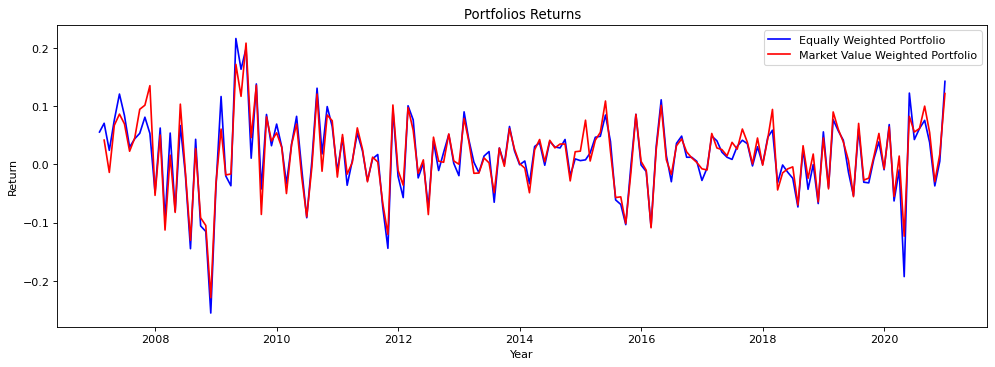

In [5]:
# Re-adding timestamps
df_returns_mv["timestamp"] = list(df_timestamp_returns)[-len(df_size):]
# Plot the chart
plt.figure(figsize = (15, 5), dpi = 80)
plt.plot(list(df_returns_mv["timestamp"]), list(monthly_port_returns_ew), color = "blue", label = "Equally Weighted Portfolio")
plt.plot(list(df_returns_mv["timestamp"][1:]), list(monthly_port_returns_mv), color = "red", label = "Market Value Weighted Portfolio")
plt.xlabel("Year")
plt.ylabel("Return")
plt.title("Portfolios Returns")
plt.legend()
plt.show()

As we can see from the plot, the two portfolio have similar returns/trends. 

## Exercise 3

**Instruction:** Supposed that you invested 100% of your wealth in the asset with the highest annualized average return computed in point 1. Compare the annualized average return and annualized volatility of this one-asset portfolio with the equally-weighted and value weighted portfolios? What explains the differences between a one-asset portfolio and a portfolio composed of many stocks? What if you invest 100% of your wealth in the asset with the highest average return computed over the first 2 years? (10 points)

Best Asset: 
index                    US62914V1061
annualized_return             1.69139
annualized_volatility         1.25656
Name: 1611, dtype: object


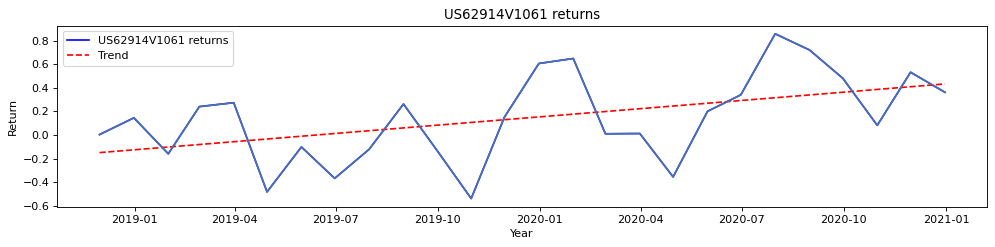

In [6]:
# Sort dataframe by return
df_solution_sorted = df_solution.sort_values(by = ['annualized_return'], ascending = False)

# Select the best performing asset
best_asset = df_solution_sorted.iloc[0]
print("Best Asset: ")
print(best_asset)

# Monthly Return of best performing asset
best_asset_monthly_returns = df_returns_mv[["timestamp", best_asset[0]]].dropna()

# Plot the chart
plt.figure(figsize = (15, 3), dpi = 80)

x = mdates.date2num(list(best_asset_monthly_returns["timestamp"]))
y = list(best_asset_monthly_returns[best_asset[0]])
plt.plot(x, y, color = "blue", label = str(best_asset[0] + " returns"))
plt.xlabel("Year")
plt.ylabel("Return")
plt.title(str(best_asset[0] + " returns"))

z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x, p(x), "r--", label = "Trend")
plt.legend()
plt.plot(list(best_asset_monthly_returns["timestamp"]), y)

The ISIN "US62914V1061NIO" corresponds to NIO, a Chinese firm operating in the automotive industry, especially active in building electric cars. NIO is our best performing asset in terms of annualized average return (~169%). 

As we can see from the graph above, the asset has a strong positive trend (*Red dashed line*), mainly driven by the results obtained from end 2019.

This asset significantly outperforms the equally weighted portfolio return (17%) and the value weighted portfolio return (~19%). 

However, we can notice that the annualized average volatility of NIO is likewise high (~126%). 
Once again, compared to the equally weighted portfolio volatility (18%) and the value weighted portfolio volatility (20%), NIO is not representative of the whole population.

With a portfolio composed of many stocks (a.k.a. a diversified portfolio), we can limit the firm-specific risk. While with a one-asset portfolio there is no diversification of the firm-specific risk, meaning that this strategy is extremely hazardous.

In [7]:
# Keep only the first two years
first_two_years = best_asset_monthly_returns[:24]
compounded_ret = expected_returns.mean_historical_return(first_two_years[best_asset[0]], returns_data = True, frequency = 24, compounding = True)[0]
print("Compounded Return: ", compounded_ret)

Compounded Return:  2.297000000000001


In the first 2 years the one-asset portfolio obtained a compounded return of ~230%.

This result means that by investing \\$1 on the primary market when NIO was listed, you would have obtained ~\\$230 after 2 years.

However, by investing 100% of the wealth in this asset a person would undertake an enormous risk, given the high volatility (~126%)., performing worse than if he/she had invested in one of the two portfolios. 

## Exercise 4

**Instruction:** For this question, limit your set of firms to 50 randomly selected firms. Build an optimal portfolio with minimum variance with monthly rebalancing. Report the following statistics: annualized average return, annualized volatility, minimum return, maximum return, and Sharpe ratio. Comment on the reported statistics in comparison with the equally-weighted and value-weighted portfolio.

In [8]:
returns_min_var = []
volatility_min_var = []
sharpe_ratio_min_var = []
# Random select 50 companies
fifty_random = df_returns_mv.drop("timestamp", 1)
fifty_random = fifty_random.sample(50, axis = 1, random_state = 24)

list_companies = []
for i in range(len(fifty_random-1)):
    # Startin from the third row
    running_data = fifty_random.iloc[:2 + i]
    # Drop Nan values in the columns
    running_data.dropna(how = 'all', axis = 1, inplace = True)
    # Computed Covariance matrix
    cov = risk_models.CovarianceShrinkage(fifty_random[running_data.columns], returns_data = True, frequency = 12).ledoit_wolf()
    
    list_companies.append(len(cov))
    
    # Computed the efficient frontier
    ef = EfficientFrontier(running_data.mean(), cov)
    ef.min_volatility()
    # Computed the Portoflio Performance
    performance = ef.portfolio_performance(risk_free_rate = df_rf_mean)
    returns_min_var.append(performance[0])
    volatility_min_var.append(performance[1])
    sharpe_ratio_min_var.append(performance[2])
    
print("\n*** Min Variance Portfolio with monthly rebalancing ***")
print("Annualized Return: ", mean(returns_min_var))
print("Annualized Volatility: ", mean(volatility_min_var))
print("Minimum Return: ", min(returns_min_var))
print("Maximum Return: ", max(returns_min_var))
print("Sharpe Ratio:", (mean(returns_min_var) - df_rf_mean) / (mean(volatility_min_var)))
print("**********************************************")


*** Min Variance Portfolio with monthly rebalancing ***
Annualized Return:  0.006799299209266268
Annualized Volatility:  0.1366580531168425
Minimum Return:  -0.016730211678433755
Maximum Return:  0.037651416301920884
Sharpe Ratio: -0.03990494702144253
**********************************************


#### Results
| Statistics | Equally Weighted | Market-value Weighted | Minimum Variance |
| --- | --- | --- | --- |
| Annualized Return | 17.28% | 18.76% | 0.07% |
| Annualized Volatility | 18.33% | 18.55% | 13.66% |
| Minimum Return | -25.50% | -23.08% | -1.67% |
| Maximum Return | 21.59% | 21.30% | 3.38% |
| Sharpe Ratio | 0.85 | 0.95 | -0.04 |

In the table above, we can see summarized the main statistics of the three portfolios computed by now.

In terms of sharpe ratio, all the portfolios are below the "minimum acceptance" threshold (<1). Focusing on the return, the Minimum Variance Portfolio is the worst one, since its return is below 2% level, which is often considered the same return of the risk-free rate. For this reason, it would not make any senses to choose the minimum variance portfolio, given the 13.66% volatility. 

Additionally, the minimum variance portfolio is the "safest" between the three, and this is also recognizable from the minimum return of -1.67%.

At the same time, the other two portfolios are slightly missing the acceptable threshold of 1. In terms of annualized average return, the equally-weighted portfolio slightly outperforms the market-value weighted portfolio (18.76% vs 17.28%). Therefore, also in this case, the best portfolio is the Market-value weighted.

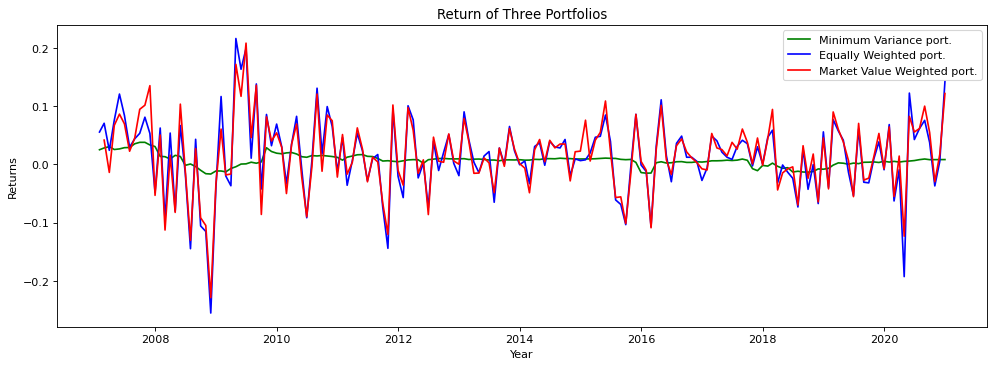

In [9]:
plt.figure(figsize = (15, 5), dpi = 80)
plt.plot(list(df_returns_mv["timestamp"]), list(returns_min_var), color = "green", label = "Minimum Variance port.")
plt.plot(list(df_returns_mv["timestamp"]), list(monthly_port_returns_ew), color = "blue", label = "Equally Weighted port.")
plt.plot(list(df_returns_mv["timestamp"][1:]), list(monthly_port_returns_mv), color = "red", label = "Market Value Weighted port.")

plt.xlabel("Year")
plt.ylabel("Returns")
plt.title("Return of Three Portfolios")
plt.legend()
plt.show()

As we can see, compared to the other two portfolios, the minimum variance one has always a constant return, which is almost always positive. Even during 2008 financial crisis and 2020 Covid market crash, the minimum variance portfolio resisted compared to the other two. This is also partially explained by the fact that the portfolio is built to minimize volatility, using the ex-post covariance matrix (i.e. Covariance Matrix computed at the end of 2020).

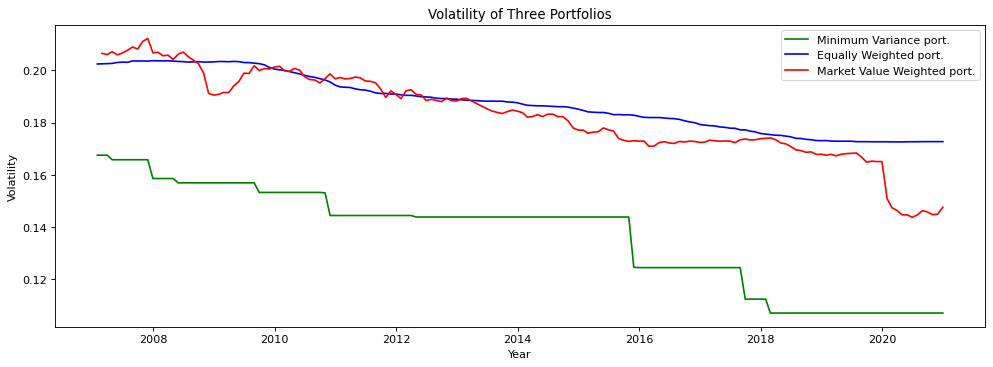

In [10]:
plt.figure(figsize = (15, 5), dpi = 80)
plt.plot(list(df_returns_mv["timestamp"]), list(volatility_min_var), color = "green", label = "Minimum Variance port.")
plt.plot(list(df_returns_mv["timestamp"]), list(monthly_port_volatility_ew), color = "blue", label = "Equally Weighted port.")
plt.plot(list(df_returns_mv["timestamp"][1:]), list(monthly_port_volatility_mv), color = "red", label = "Market Value Weighted port.")

plt.xlabel("Year")
plt.ylabel("Volatility")
plt.title("Volatility of Three Portfolios")
plt.legend()
plt.show()

As we can see, the volatility of the three portfolio decreases with years. At the same time, the volatility of the minimim variance portfolio needs to be further investigates since it decreases sharply in *appareantly* random periods.

It is important to mention that the equally weighted and market value weighted portofolios are better representative of the market trends, since they include more than 1.000 companies. While, the minimum variance portfolio is a mix of 50 random selected companies.

Text(0.5, 1.0, 'Minimum Variance Portfolio: Volatility vs # of companies in the portfolio')

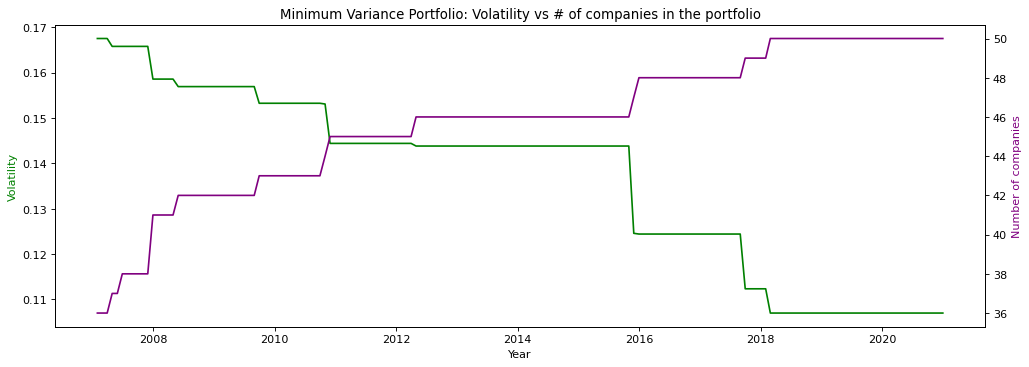

In [11]:
fig, ax1 = plt.subplots(figsize = (15, 5), dpi = 80)
ax2 = ax1.twinx()
ax1.plot(list(df_returns_mv["timestamp"]), list(volatility_min_var), 'g-')
ax2.plot(list(df_returns_mv["timestamp"]), list(list_companies), 'purple')

ax1.set_xlabel('Year')
ax1.set_ylabel('Volatility', color='g')
ax2.set_ylabel('Number of companies', color='purple')

plt.title("Minimum Variance Portfolio: Volatility vs # of companies in the portfolio")

In the plot above, we tried to investigate the reason behind the sharp decrease of volatility displayed in the graph "Volatility of Three Portfolios". We can observe that a rapid decrease in volatility corresponds to a increase in the number of companies available. We considered only available companies, because in several months we didn't have information for some companies (i.e. Nan values).

## Exercise 5

**Instruction:** For this question, keep the same randomly selected firms from the previous point. Build an optimal portfolios with various target portfolio returns (e.g., from 2% to 16% with 2% increments). Plot the efficient frontier as well as the individual assets. Which portfolio is the most efficient in terms of Sharpe ratio? (15 points)

In [12]:
list_weights = []
# Get the Covariance matrix of 50 random companies
cov = risk_models.CovarianceShrinkage(fifty_random, returns_data = True, frequency = 12).ledoit_wolf()

# Computed the Efficient frontier
ef = EfficientFrontier(fifty_random.mean(), cov)
last = 0
portfolios = []

for i in range(2,18,2):
    print("")
    try:        
        last = ef.efficient_return(i/100)
        portfolios.append(ef.portfolio_performance(True,risk_free_rate = df_rf_mean))
    except:
        # Compute the Expected Annual Return which is not multiple of 2
        for j in range(1,20):
            try:
                last = ef.efficient_return(((i-2)/100)+(j/1000))            
            except:
                print("**********************************************\n")
                print("Max possible return:")
                portfolios.append(ef.portfolio_performance(True, risk_free_rate = df_rf_mean))
                break
        break


Expected annual return: 2.0%
Annual volatility: 12.6%
Sharpe Ratio: 0.06

Expected annual return: 4.0%
Annual volatility: 22.8%
Sharpe Ratio: 0.12

**********************************************

Max possible return:
Expected annual return: 5.8%
Annual volatility: 47.3%
Sharpe Ratio: 0.10


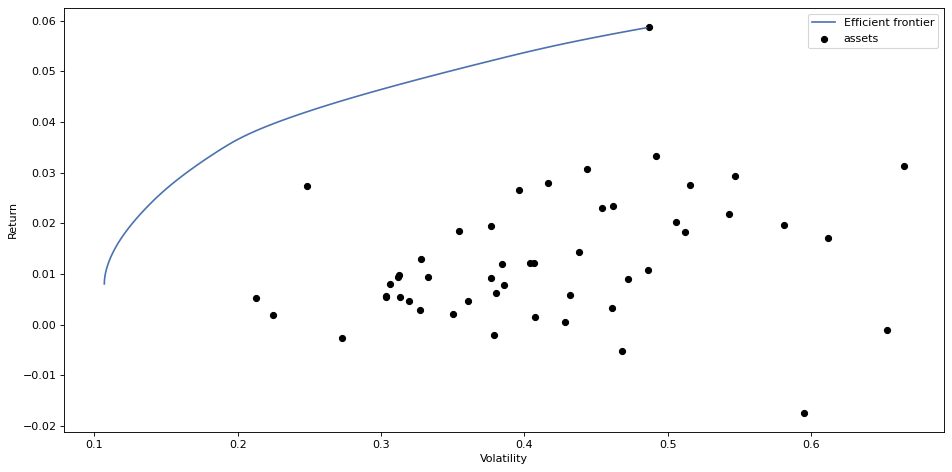

In [13]:
# Plot the chart
plt.figure(figsize = (12, 6), dpi = 80)
plotting.plot_efficient_frontier(EfficientFrontier(fifty_random.mean(), cov))

From the image above, we can see our Efficient Frontier in terms of mean variance. It's interesting to see how individual assets are sub-optimal compared to efficient diversificated portfolio, meaning that that they cannot provide the same level of return for a given risk.

All rational investors will invest in this frontier given their risk adversion and utility function. In order to have the highest return possible, you should invest 100% of your wealth in the asset with the higheset return.

In [14]:
best_sharpe_ratio = max(portfolios, key = operator.itemgetter(2))

def ef_stats(stats):
    print("Expected annual return: ", stats[0]*100, "%")
    print("Annual volatility: ", stats[1]*100, "%")
    print("Sharpe Ratio: ", stats[2])

print("*** Most efficient portfolio in term of sharpe ratio ***")    
ef_stats(best_sharpe_ratio)

*** Most efficient portfolio in term of sharpe ratio ***
Expected annual return:  4.000000000000003 %
Annual volatility:  22.777187773238214 %
Sharpe Ratio:  0.12182087050120437


The most efficient portfolio in terms of Sharpe ratio is the portfolio with 6% of expected annual return. However, this portfolio has a Sharpe ratio of 0.12, which is usually considered not acceptable by investors (i.e. below the "critical" threshold of 1).

## Exercise 6

**Instruction:** Choose an appropriate benchmark, which should correspond to the region of your dataset. Compare the performance of your portfolios (equally-weighted, value-weighted, and minimum variance) with the benchmark. Comment on the differences. (10 points)

We decided to pick as a benchmark the **MSCI Emerging Markets Index**, which is a selection of stocks that is designed to track the financial performance of key companies in fast-growing nations.

Then, we retrieved historical data from <a href = "https://backtest.curvo.eu/market-index/msci-emerging-markets">this source</a>.

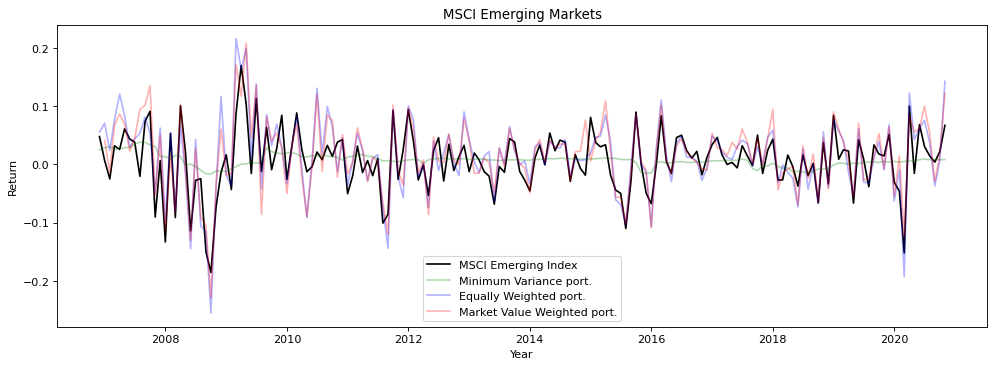


*** MSCI Emerging Market Index ***
Annualized Return:  0.07338925370573134
Annualized Volatility:  0.1794804317958342
Minimum Return:  -0.18549312285868358
Maximum Return:  0.16946313913526434
Sharpe Ratio: 0.3406311290599591
**********************************************


In [15]:
# Get the path of the file
benchmark = os.path.join(DATA, "MSCI_Emerging_Markets_Index.csv")
# Load the data
df_benchmark = pd.read_csv(benchmark, index_col = 0)
# Compute percentage change
df_benchmark_returns = df_benchmark.pct_change()
# Slice the dataframe keeping the same time horizon given the different market closure
df_benchmark_returns = df_benchmark_returns.loc["2006-12": "2020-11"]

# Compute annualized return
df_ben_mean = df_benchmark_returns.mean()*12
benchmark_annualized_volatility = np.std(df_benchmark_returns)*np.sqrt(12)

t = pd.to_datetime(list(df_benchmark_returns.index))
x = list(df_benchmark_returns["MSCI Emerging Markets"])

fig, ax = plt.subplots(figsize = (15, 5), dpi = 80)
ax.plot(t,x, color = "black", label = "MSCI Emerging Index")

plt.plot(t, list(returns_min_var), color = "green", label = "Minimum Variance port.", alpha = 0.3)
plt.plot(t, list(monthly_port_returns_ew), color = "blue", label = "Equally Weighted port.", alpha = 0.3)
plt.plot(t[1:], list(monthly_port_returns_mv), color = "red", label = "Market Value Weighted port.", alpha = 0.3)

plt.xlabel("Year")
plt.ylabel("Return")
plt.title("MSCI Emerging Markets")
plt.legend()
plt.show()

print("\n*** MSCI Emerging Market Index ***")
print("Annualized Return: ", df_ben_mean[0])
print("Annualized Volatility: ", benchmark_annualized_volatility[0])
print("Minimum Return: ", df_benchmark_returns.min()[0])
print("Maximum Return: ", df_benchmark_returns.max()[0])
print("Sharpe Ratio:", (df_ben_mean[0] - df_rf_mean) / (benchmark_annualized_volatility[0]))
print("**********************************************")

#### Results
| Statistics | Equally Weighted | Market-value Weighted | Minimum Variance | MSCI Emerging Market Index |
| --- | --- | --- | --- | --- |
| Annualized Return | 17.28% | 18.76% | 0.07% | 7.34% |
| Annualized Volatility | 18.33% | 18.55% | 13.66% | 17.95% |
| Minimum Return | -25.50% | -23.08% | -1.67% | -18.55% |
| Maximum Return | 21.59% | 21.30% | 3.38% | 16.95% |
| Sharpe Ratio | 0.85 | 0.95 | 0.05 | 0.34 |

As we can see from the table above, the MSCI Emerging Market Index has a return of 7.34%, which is massively lower compared to our Equally Weighted and Market-value Weighted portfolios, but this difference is not mirrored in the volatility, since it is just 1% point lower than the other two. This negative performance is also relfected in a lower sharpe ratio (0.34).

In conclusion, for the time period taken into account, we can state that Equally Weighted and Market-value Weighted portfolios perform better than the MSCI Emerging Market Index. 

## Exercise 7

**Instruction:** Compute and comment on the simple correlation between returns, volatility, size. (5 points)

In [16]:
# Set the index
df_corr = df_solution.set_index("index")
# Compute the average return
df_corr["size"] = list(df_size.mean().sort_index())
# Compute the correlation matrix
df_corr.corr()

,annualized_return,annualized_volatility,size
annualized_return,1.000000,0.381584,-0.000103
annualized_volatility,0.381584,1.000000,-0.005272
size,-0.000103,-0.005272,1.000000


The correlation between annualized average return and annualized average volatility is 0.38. Once again, this means that the two variables are positevely correlated.

Secondly, the correlation between annualized average return and size (in terms of market cap), and the correlation between annualized average volatility and size (in terms of market cap) are in both cases close to zero. This means that there is no correlation between these two variables and the size, therefore, <u>the size of a company is not a good predictor for returns and/or volatility</u>.

## Exercise 8

**Instruction:** For this question, take the same 50 selected firms. You now create a minimum variance portfolio with monthly rebalancing with an additional constraint: you exclude the smallest firms (bottom tercile of the distribution of the firms’ market capitalization in month t − 1). Report summary statistics on the performance of this portfolio and comment on the differences with the minimum variance from point 4. (15 points)


*** Min Variance Portfolio with monthly rebalancing of top tercile***
Annualized Return:  0.007196386382912947
Annualized Volatility:  0.13801135761830224
Minimum Return:  -0.020477771529280254
Maximum Return:  0.03776329694748181
Sharpe Ratio: -0.036636442705088444
**********************************************


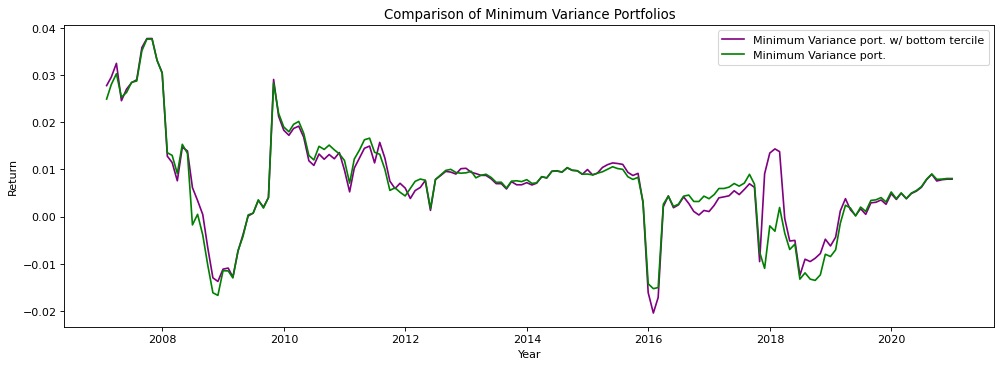

In [17]:
df_random_sizes = df_size[fifty_random.columns]
# Function to drop for the dataset those assets with last tercile size value
def get_last_tercile(market_value):
    # Get t-1
    raw = market_value.iloc[[-2]]
    tercile = market_value.iloc[-2].quantile(1/3)
    return raw.drop(columns = raw.columns[(raw < tercile).any()]).columns

returns_min_var_top = []
volatility_min_var_top = []
# Take only those columns for wich we have both size and return info
fifty_random = fifty_random[-len(df_random_sizes):]

for i in range(len(fifty_random -1)):
    running_data = fifty_random.iloc[:2 + i]
    running_sizes = df_random_sizes[:2 + i]
    # Remove last tercile 
    running_data = running_data[get_last_tercile(running_sizes)]
    # Drop Nan values in the columns
    running_data.dropna(how = 'all', axis = 1, inplace = True)
    cov = risk_models.CovarianceShrinkage(fifty_random[running_data.columns], returns_data = True, frequency = 12).ledoit_wolf()
    # Compute portfolio performances
    ef = EfficientFrontier(running_data.mean(), cov)
    ef.min_volatility()
    # Compute portfolio performances
    performance = ef.portfolio_performance(risk_free_rate = df_rf_mean)
    returns_min_var_top.append(performance[0])
    volatility_min_var_top.append(performance[1])

print("\n*** Min Variance Portfolio with monthly rebalancing of top tercile***")
print("Annualized Return: ", mean(returns_min_var_top))
print("Annualized Volatility: ", mean(volatility_min_var_top))
print("Minimum Return: ", min(returns_min_var_top))
print("Maximum Return: ", max(returns_min_var_top))
print("Sharpe Ratio:", (mean(returns_min_var_top) - df_rf_mean) / (mean(volatility_min_var_top)))
print("**********************************************")

plt.figure(figsize = (15, 5), dpi = 80)
plt.plot(list(df_returns_mv["timestamp"]), list(returns_min_var_top), color = "purple", label = "Minimum Variance port. w/ bottom tercile")
plt.plot(list(df_returns_mv["timestamp"]), list(returns_min_var), color = "green", label = "Minimum Variance port.")
plt.xlabel("Year")
plt.ylabel("Return")
plt.title("Comparison of Minimum Variance Portfolios")
plt.legend()
plt.show()

#### Results
| Statistics |Minimum Variance | Minimum Variance no bottom tercile |
| --- | --- | --- |
| Annualized Return | 0.07% | 0.72% |
| Annualized Volatility | 13.66% | 13.80% |
| Minimum Return | -1.67% | -2.04% |
| Maximum Return | 3.38% | 3.78% |
| Sharpe Ratio | -0.04 | -0.04 |

As we can see from the graph above (and also from the table), excluding the firms with the smallest market cap means excluding the firms with the highest growth potential. This is reflected in the return, since the purple portfolio has a return lower than the green one. 

At the same time, the volatility is almost the same, which means that bigger companies are not less volatile than smaller ones. Given the low return, even in this case, it would result more convenient to invest in risk free rate assets.

## Exercice 9

**Instruction:** For each time period, sort firms based on size into quintiles. Create equally-weighted and value-weighted portfolios for each time period and each size quintile. Report the average returns for each quintile portfolio as well as a portfolio that goes long in the lowest quintile and short the highest quintile. Comment on your results. What can explain the relationship between returns of your portfolio and firms’ size? Repeat this exercise but sorting firms based on past stock returns. Compute past returns in month t as the cumulated return of a firms between months t − 13 and t − 1. (15 points)

In [18]:
def quintile_portfolio(category):
    final_port_ret = 0
    dict_month_weight = {}
    dict_month_return = {}
    
    # For each time period, sort firms based on size into quintiles. 
    df_returns_chopped = df_returns[-len(df_size):].reset_index().drop(["index"], 1)
    # Update the dictionary with the weight that has in our portfolio
    for company in df_size.columns:
        dict_month_weight.update({company : 0})

    five_df_month = []
    for month in range(len(df_size)):

        new_df = pd.DataFrame(None)
        new_df["firms"] = list(df_returns_chopped.columns)
        new_df["returns"] =  list(df_returns_chopped.iloc[month])

        if category == "sizes":
            # Put -1 for referencing for to the previous month
            new_df["sizes"] = list(df_size.iloc[month-1])
            new_df["market_value"] = list(df_size.iloc[month-1])
        elif category == "returns":
            # Put -1 for referencing for to the previous month
            new_df["sizes"] = list(df_returns_chopped.iloc[month-1])
            new_df["market_value"] = list(df_size.iloc[month-1])
        elif category == "12months":
            # Skip the first 12 months to apply the cumulative sum
            if month in range(0,12):
                continue
            else:
                # Do the cumulative sum of the last 12 months
                new_df["sizes"] = list(df_returns_chopped.iloc[month-12:month].cumsum().iloc[-1])          
                new_df["market_value"] = list(df_size.iloc[month-1])
                
        # Sorted companies and dropped companies where the size was Nan
        df_sorted_sizes = new_df.sort_values("sizes").dropna()
        # Get the length of the dataset
        df_length = len(df_sorted_sizes)
        # Get the number of rows to divide into quintiles
        div = df_length//5

        # Build the initial portofolio
        if month == 0 or (category == "12months" and month == 12):
            # Get the weight of each company in the portfolio
            weights_eq = np.array([1/df_length]*df_length)

            # Compute weighted return
            avg_ret_eq = np.average(df_sorted_sizes.returns, weights = weights_eq)

            # Add to the initial portfolio
            final_port_ret += avg_ret_eq
            
            # Add to the dict
            dict_month_return.update({month : avg_ret_eq})

            # Update the dictionary with the weight that has in our portfolio
            for company in df_sorted_sizes.firms:
                dict_month_weight.update({company : 1/df_length})
        else:
            # Best performing quintile
            firms_to_remove = df_sorted_sizes[div*4:].firms
            # Worst performing quintile
            firms_to_buy = df_sorted_sizes[:div].firms

            # Get the weights of the best quintile
            weight_to_reinvest = sum([dict_month_weight[k] for k in firms_to_buy])/len(firms_to_buy)

            # Remove the weights of the sold companies
            for company in firms_to_remove:
                dict_month_weight.update({company : 0})

            # Re allocate the weights of the best performing quintiles
            for company in firms_to_buy: 
                dict_month_weight[company] += weight_to_reinvest

            # Convert a dict into a dataframe
            df_month_weight = pd.DataFrame(dict_month_weight.items(), columns = ['firms', 'weights'])

            # Merge the two dataframes
            df_merged = df_sorted_sizes.merge(df_month_weight)

            # Compute weighted return
            avg_ret = np.average(df_merged.returns, weights = df_merged.weights)

            # Add to the initial portfolio
            final_port_ret += avg_ret

            # Add to the dict
            dict_month_return.update({month : avg_ret})

        five_df = [df_sorted_sizes[:div], df_sorted_sizes[div:div*2], df_sorted_sizes[div*2:div*3], df_sorted_sizes[div*3:div*4], df_sorted_sizes[div*4:]]

        five_df_month.append(five_df)

    ann_ret_new_port = final_port_ret/len(df_size)*12
    
    return ann_ret_new_port, five_df_month, dict_month_return

In [19]:
def long_short (df):
    low_month_ret_eq = []
    high_month_ret_eq = []
    low_month_ret_mv = []
    high_month_ret_mv = []

    for month in range(len(df)):
        
        if month == 0: continue
        else:
            # Equally weighted
            lowest_quint = df[month][0].returns
            highest_quint = df[month][-1].returns*-1
            low_month_ret_eq.append(lowest_quint.mean())
            high_month_ret_eq.append(highest_quint.mean())

            # Value market weighted
            weights_mv_low = df[month][0].market_value
            avg_ret_mv_low = np.average(lowest_quint, weights = weights_mv_low)
            
            weights_mv_high = df[month][-1].market_value
            avg_ret_mv_high = np.average(highest_quint, weights = weights_mv_high)
            
            low_month_ret_mv.append(avg_ret_mv_low)
            high_month_ret_mv.append(avg_ret_mv_high)
        
    return mean(low_month_ret_eq)*12, mean(high_month_ret_eq)*12, mean(low_month_ret_mv)*12, mean(high_month_ret_mv)*12

In [20]:
ann_ret_new_port_sizes, five_df_month_sizes, month_return_sizes = quintile_portfolio("sizes")
ann_ret_new_port_returns, five_df_month_returns, month_return_returns = quintile_portfolio("returns")
ann_ret_new_port_cumsum, five_df_month_cumsum, month_return_cumsum = quintile_portfolio("12months")
    
def final_quintiles(dictionary):
    for k,v in dictionary.items():
        dictionary[k] = (v/len(df_size))*12
    return dictionary
    
def compute_quintiles(five_df_month):
    final_eq = {0:0, 1:0, 2:0, 3:0, 4:0}
    final_mv = {0:0, 1:0, 2:0, 3:0, 4:0}
    
    for month in range(len(five_df_month)):
        for quant in range(0,5):
            # Get the returns for that month
            ret = five_df_month[month][quant].returns
            # Equally weighted
            weights_eq = np.array([1/five_df_month[month][quant].shape[0]]*five_df_month[month][quant].shape[0])
            avg_ret_eq = np.average(ret, weights = weights_eq)
            # Skip the first month since we allocate from the second month
            if month != 0:
                # Value market weighted
                weights_mv = five_df_month[month][quant].market_value
                avg_ret_mv = np.average(ret, weights = weights_mv)
            else:
                # Only for the first month we use the same return of the equaly weighted portfolio
                avg_ret_mv = avg_ret_eq

            final_eq[quant] += avg_ret_eq
            final_mv[quant] += avg_ret_mv

    return list(final_quintiles(final_eq).values()), list(final_quintiles(final_mv).values())
 

### Based on Sizes

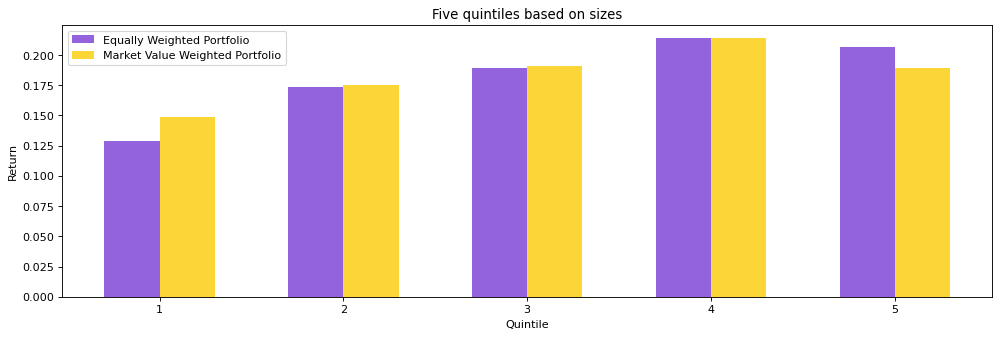

In [21]:
x, y = compute_quintiles(five_df_month_sizes)
X_axis = list(range(1,6))

r = np.arange(5)
plt.figure(figsize = (15, 4.5), dpi = 80)
plt.bar(r, x, color = "#9263DD",width = 0.30, label = 'Equally Weighted Portfolio')
plt.bar(r + 0.30, y, color = '#FBD636', width = 0.30, label = 'Market Value Weighted Portfolio')
plt.xlabel("Quintile")
plt.ylabel("Return")
plt.title("Five quintiles based on sizes")
plt.xticks(r + 0.30/2, X_axis)
plt.legend()
plt.show()

From the histogram above, for each month, we created five portfolios, and we plotted the average return for each portfolio. We can observe that for relatively small-sized companies (first quintile) a value-weighted portfolio strategy tends to be more valuable, while for relatively big-sized companies (fifth quintile) the opposite seems to be true, namely the equally weighted strategy tends give back higher returns. A possible explanation is that in the extremes of the distribution the difference in sizes can be significant.

Contrary to what happens in the extremes, in the second, third and fourth quintiles there is no dominant strategy (Equally vs Market value weighted).

Given the correlation computed in exercise #7, we were expecting that all the quintiles would have been on the same level (i.e. similar return), but this is not the case because mentioned correlation was computed between average annualized average values, while in short-term we can see that there is a relevant correlation between size and return.

It is interesting to notice that we divided our companies into quintiles according to their size. However, we haven't taken into account any measurement scale, a proper threshold to identify which companies are actually small, mid or big-sized. For this concern <a href="https://www.merrilledge.com/article/company-size-why-market-capitalization-matters-ose">Bank of America</a> suggests three reliable thresholds:
- less than 3 billion market cap for small-sized
- between 3 and 10 billion for mid-sized
- more than 10 billion for big-sized companies. 

With this kind of measurement scale, the strategy used above would make way more sense, since we would have been sure to go long on firms with a small market cap, and therefore an higher return potential, and short sell on the firms with a big size, meaning those which already reached their plateau and therefore more subjected to potential losses.

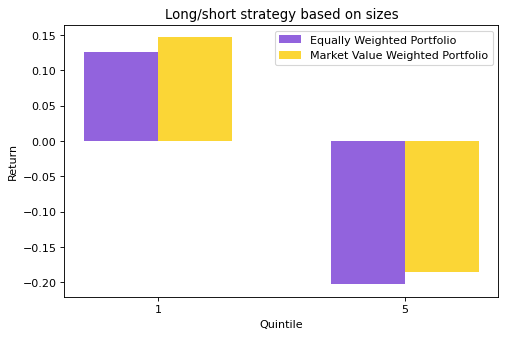

*** Equally Weighted Portfolio ***
Return of the strategy: -0.0766873986146018

*** Market Value Weighted Portfolio ***
Return of the strategy: -0.03888726381255231


In [22]:
low_month_ret_eq_size, high_month_ret_eq_size, low_month_ret_mv_size, high_month_ret_mv_size = long_short(five_df_month_sizes)
low_month_ret_eq_ret, high_month_ret_eq_ret, low_month_ret_mv_ret, high_month_ret_mv_ret = long_short(five_df_month_returns)
low_month_ret_eq_cum, high_month_ret_eq_cum, low_month_ret_mv_cum, high_month_ret_mv_cum = long_short(five_df_month_cumsum)

X_axis = list(range(1,6,4))
r = np.arange(2)
plt.figure(figsize = (7, 4.5), dpi = 80)
plt.bar(r, [low_month_ret_eq_size, high_month_ret_eq_size], color = "#9263DD", width = 0.30, label = 'Equally Weighted Portfolio')
plt.bar(r + 0.30, [low_month_ret_mv_size, high_month_ret_mv_size], color = '#FBD636', width = 0.30, label = 'Market Value Weighted Portfolio')
plt.xlabel("Quintile")
plt.ylabel("Return")
plt.title("Long/short strategy based on sizes")
plt.xticks(r + 0.30/2, X_axis)
plt.legend()
plt.show()
print("*** Equally Weighted Portfolio ***")
print("Return of the strategy:", low_month_ret_eq_size + high_month_ret_eq_size)
print()
print("*** Market Value Weighted Portfolio ***")
print("Return of the strategy:", low_month_ret_mv_size + high_month_ret_mv_size)

The results displayed in the graph above are based on the following strategy: each month (t) we rely on the companies' size of the previous month (t-1) since we want to go long on the assets with the smallest size (first quintile) and short sell the assets with the biggest size (fifth quintile). 

According to this strategy the smallest firms should drive the overall positive returns in upcoming month (t), while the firms with the biggest size should have already reached their target value and therefore they should have had negative returns in the next month (t). 

However, this is not the case. As seen in the graph plotted in the previous chunck of code, high capitalized companies on average return more than the smallest ones. As a consequence, the returns of both portofolios are negative.

Addionally, we can remark that short-selling is not profitable since in the last years (i.e. time horizon taken into account) the markets have always increased, and this is also shown in the exercise #6, when we considered the MSCI Emerging Markets Index.

### Based on Returns

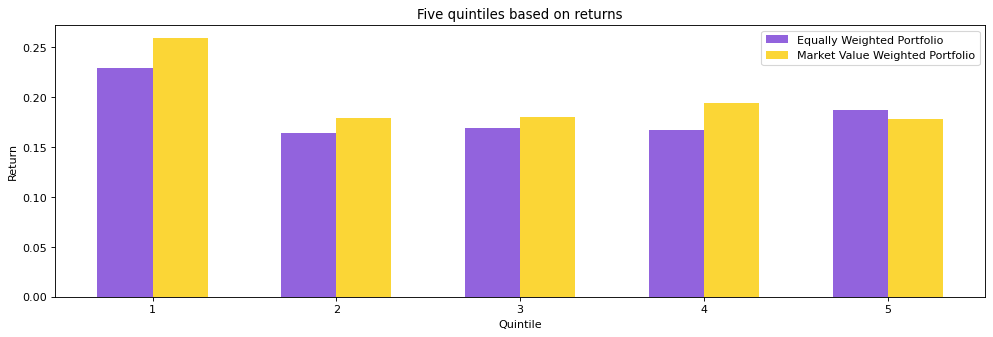

In [23]:
x, y = compute_quintiles(five_df_month_returns)
X_axis = list(range(1,6))
r = np.arange(5)
plt.figure(figsize = (15, 4.5), dpi = 80)
plt.bar(r, x, color = "#9263DD", width = 0.30, label = 'Equally Weighted Portfolio')
plt.bar(r + 0.30, y, color = '#FBD636', width = 0.30, label = 'Market Value Weighted Portfolio')
plt.xlabel("Quintile")
plt.ylabel("Return")
plt.title("Five quintiles based on returns")
plt.xticks(r + 0.30/2, X_axis)
plt.legend()
plt.show()

From the graph above, we can observe that the companies with lowest return in t-1 (first quintile) tend to outperfom the following month (t). On average, the overall returns of this strategy is lower compared to the previous one (based on sizes).

At the same time, it is relevant to highlight that the market-value weighted portoflios outperform the equally weighted ones four out of five. A possible explanation of this pattern is that large companies, which faced a negative return, are more prone to have a rebound effect.

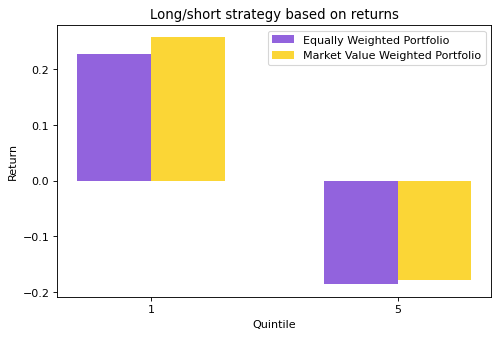

*** Equally Weighted Portfolio ***
Return of the strategy: 0.041160158554658655

*** Market Value Weighted Portfolio ***
Return of the strategy: 0.07966299719771677


In [24]:
X_axis = list(range(1,6,4))
r = np.arange(2)
plt.figure(figsize = (7, 4.5), dpi = 80)
plt.bar(r, [low_month_ret_eq_ret, high_month_ret_eq_ret], color = "#9263DD", width = 0.30, label = 'Equally Weighted Portfolio')
plt.bar(r + 0.30, [low_month_ret_mv_ret, high_month_ret_mv_ret], color = '#FBD636', width = 0.30, label = 'Market Value Weighted Portfolio')
plt.xlabel("Quintile")
plt.ylabel("Return")
plt.title("Long/short strategy based on returns")
plt.xticks(r + 0.30/2, X_axis)
plt.legend()
plt.show()

print("*** Equally Weighted Portfolio ***")
print("Return of the strategy:", low_month_ret_eq_ret + high_month_ret_eq_ret)
print()
print("*** Market Value Weighted Portfolio ***")
print("Return of the strategy:", low_month_ret_mv_ret + high_month_ret_mv_ret)

In the graph above, we can see that the market-value weighted portfolios, performed better compared to hte equally weighted one, in both the cases (first and fift quintiles). Once again, this pattern can be explained by the fact that larger companies tend to outperform smallest ones. This extremely relevant, since market-value weighted portfolios have almost doubled the return of equally weighted one.

Addionally, we can remark that short-selling is not profitable since in the last years (i.e. time horizon taken into account) the markets have always increased, and this is also shown in the exercise #6, when we considered the MSCI Emerging Markets Index.

Finally, it is interesting to point out how this return-sorted strategy has (in both the cases) a positive return, which is better than the size-sorted strategy.

### Based on last 12 months cumulative sum

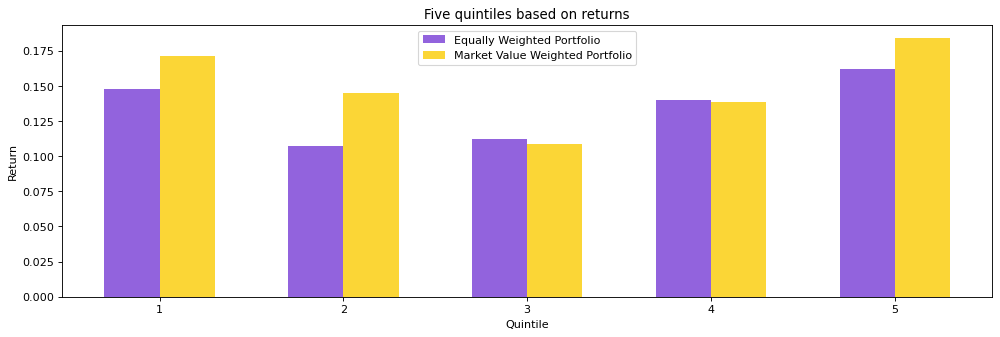

In [25]:
x, y = compute_quintiles(five_df_month_cumsum)
X_axis = list(range(1,6))

r = np.arange(5)
plt.figure(figsize = (15, 4.5), dpi = 80)
plt.bar(r, x, color = "#9263DD",width = 0.30, label = 'Equally Weighted Portfolio')
plt.bar(r + 0.30, y, color = '#FBD636', width = 0.30, label = 'Market Value Weighted Portfolio')
plt.xlabel("Quintile")
plt.ylabel("Return")
plt.title("Five quintiles based on returns")
plt.xticks(r + 0.30/2, X_axis)
plt.legend()
plt.show()

In this case, we created different quintiles based on the average returns of the last 12 months. This strategy differs from the previous one (i.e. monthly based return sorted), because the average return of one year is less sensitive to monthly perfomances. Therefore, the same companies can be found more often in the same quintiles.

Once again, market-value weighted portfolios have better perfomances compared to equally weighted ones in the majority of the quintiles. Therefore, the market sizes help to drive up the returns.

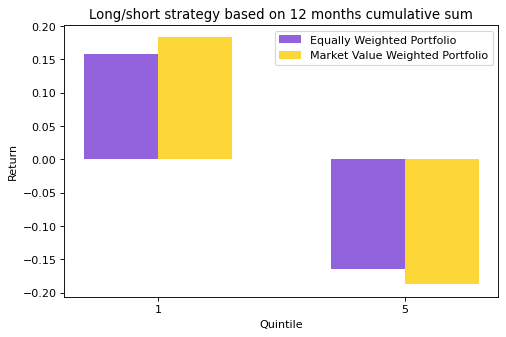

*** Equally Weighted Portfolio ***
Return of the strategy: -0.006469398338391247

*** Market Value Weighted Portfolio ***
Return of the strategy: -0.004654537174045931


In [26]:
X_axis = list(range(1,6,4))
r = np.arange(2)
plt.figure(figsize = (7, 4.5), dpi = 80)
plt.bar(r, [low_month_ret_eq_cum, high_month_ret_eq_cum], color = "#9263DD", width = 0.30, label = 'Equally Weighted Portfolio')
plt.bar(r + 0.30, [low_month_ret_mv_cum, high_month_ret_mv_cum], color = '#FBD636', width = 0.30, label = 'Market Value Weighted Portfolio')
plt.xlabel("Quintile")
plt.ylabel("Return")
plt.title("Long/short strategy based on 12 months cumulative sum")
plt.xticks(r + 0.30/2, X_axis)
plt.legend()
plt.show()

print("*** Equally Weighted Portfolio ***")
print("Return of the strategy:", low_month_ret_eq_cum + high_month_ret_eq_cum)
print()
print("*** Market Value Weighted Portfolio ***")
print("Return of the strategy:", low_month_ret_mv_cum + high_month_ret_mv_cum)

Also in this case, we can remark that short-selling is not profitable since in the last years (i.e. time horizon taken into account) the markets have always increased, and this is also shown in the exercise #6, when we considered the MSCI Emerging Markets Index.

### Our Strategy

Our strategy is based on the exercises #9. 

We started from scratch, by equally allocating weights to all the available companies. Then for each month, we retrieved information from the previous month (i.e. size, return and 12 months returns average), and, as done before, we splitted them into quintiles. 

At this point, we decided to sell the companies which were located in the fifth quintiles (e.g. best performing firms), and we reallocated the disinvested capital in the lowest quintile.

In [27]:
print("Return of Size weighted portfolio: ", ann_ret_new_port_sizes)
print("\nReturn of Return weighted portfolio: ", ann_ret_new_port_returns)
print("\nReturn of 12 months average weighted portfolio: ", ann_ret_new_port_cumsum)

Return of Size weighted portfolio:  0.22122443268486683

Return of Return weighted portfolio:  0.20569354495799116

Return of 12 months average weighted portfolio:  0.14785319078802578


**Size-sorted**:
As we can see from the results above, the size weighted portfolio results to be the best performing ones. Embracing this strategy means that we are betting on the growth of the small sizes companies, while we are arguing that high market cap companies have already reached a kind of plateau, meaning that those companies will not have big growth opportunities.

**Return-sorted**:
At the same time, we can observe that the past return offers a good benchmark to follow the above mentioned strategy, but the performance are slightly lower compared to the previous strategy. 

**12 months-sorted**:
In this case, we computed the cumulative sum of the returns of the previuos 12 months for each company, and as did before we disinvested in the companies that reported a high performance in the last year, and reallocated the capital in the lowest performing one. As we can see, in this case we have a return of only 14%, which is lower compared to the previous two strategies. This could be explained by the fact that a company that bad performed for a longer time horizon could have more difficulties in recovering. On the other hand, the opposite would be true for high performing companies.

**Conclusion**:
As a side note, we can denote that all three strategies performed better than the MSCI Emerging Countries Index, which for the same time span taken into account, reported a return of around 7%. At the same time, we decided to pursue this strategy to try to beat the short-selling strategy.
